# Play with LaTex Content 

In [ ]:
import re, os, shutil, datetime
from datasets import load_dataset
from pylatex import Document, NoEscape
from pdf2image import convert_from_path
from IPython.display import Image, display




/Users/shuaizou/Desktop/NLP - Group Assignment/RAG_on_arXiv_ML/nlp_env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Preliminary Analysis

Provides an initial exploration of the [staghado/ArXiv-tables](https://huggingface.co/datasets/staghado/ArXiv-tables) dataset from Hugging Face.<br>The goal is to understand the structure, content length distribution, and vocabulary characteristics of LaTeX-formatted tables extracted from arXiv papers.

###  Load Dataset

This loads the "train" split of the dataset.

In [ ]:
dataset = load_dataset("staghado/ArXiv-tables")
dataset = dataset["train"]



### Look at the structure and fields

This prints the keys (field names) of a single sample entry.<br>Example fields include: id, arxiv_id, page, bounding_box, latex_content, extracted_content, similarity_score, table_image, page_image.

In [ ]:
print(dataset.column_names)

['id', 'arxiv_id', 'page', 'bounding_box', 'latex_content', 'extracted_content', 'similarity_score', 'table_image', 'page_image']


### Dataset Size & Number of documents

Displays the total number of entries in the dataset.<br>In this case, it confirms the dataset has 1328 table entries.

In [ ]:
print("Total number of samples：", len(dataset))

Total number of samples： 1328


### Analyze field contents (document content, length distribution)

Converts the LaTeX content into strings and measures their character length.<br>Stores the lengths in a pandas DataFrame.<br>Uses .plot.hist() to draw a histogram with 30 bins to visualize how LaTeX lengths are distributed.<br>Most LaTeX contents are short; a few outliers are very long.

In [ ]:
!pip3 install matplotlib


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


<Axes: title={'center': 'Length Distribution of LaTeX content'}, ylabel='Frequency'>

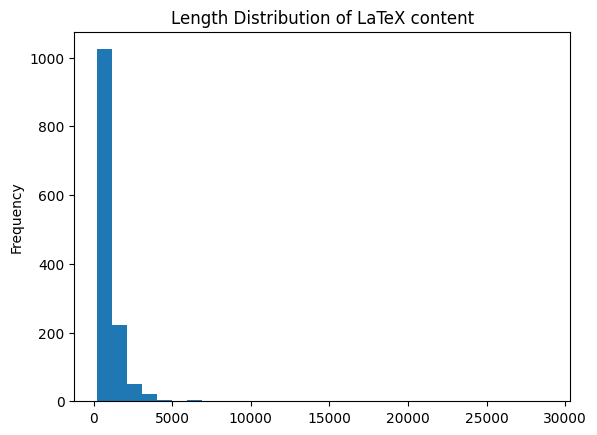

In [ ]:
import pandas as pd
lengths = [len(str(x["latex_content"])) for x in dataset]
df = pd.DataFrame({"length": lengths})
df["length"].plot.hist(bins=30, title="Length Distribution of LaTeX content")

### Estimate Approximate Vocabulary Size

Samples the first 500 entries for faster processing.<br>Uses a regular expression \\?[a-zA-Z_]+ to extract “words” from LaTeX: It matches both LaTeX commands (e.g., \hline) and normal words (e.g., score, _avg).<br>Counter is used to keep track of how many times each word appears.<br>Finally, len(vocab) gives the total number of unique tokens (estimated vocabulary size).<br>Result: approx. 7517 unique words.

In [ ]:
from collections import Counter
import re

vocab = Counter()
for entry in dataset.select(range(500)):  # sample 500 entries
    words = re.findall(r'\\?[a-zA-Z_]+', entry["latex_content"])
    vocab.update(words)

print("Estimated vocabulary size：", len(vocab))

Estimated vocabulary size： 7517


### Summary

Loaded 1328 LaTeX-formatted table entries.<br>Visualized content length distribution using a histogram.<br>Extracted and counted unique words from LaTeX to estimate vocabulary size.<br>These steps provide useful statistics for further tasks like table understanding, structure extraction, and embedding training.

## Table Modification

## Table data modification 

In [ ]:
def modify_numeric_values(latex_str, old_val, new_val):
    return latex_str.replace(old_val, new_val)

## Table structure modification

In [ ]:
def modify_column_spec(latex_line, default_addition="p{3cm}|", conditional_target="c|", conditional_addition="|c"):
    brace_count = 0
    first_done = False
    start_idx = None
    end_idx = None

    for i, char in enumerate(latex_line):
        if char == '{':
            brace_count += 1
            if brace_count == 1 and not first_done:
                first_done = True
            elif brace_count == 1 and first_done and start_idx is None:
                start_idx = i + 1  # content starts after this
        elif char == '}':
            if brace_count == 1 and start_idx is not None and end_idx is None:
                end_idx = i  # content ends before this
                break
            brace_count -= 1

    if start_idx is not None and end_idx is not None:
        # Get original column spec
        colspec = latex_line[start_idx:end_idx]
        if conditional_target in colspec:
            addition = conditional_addition
        else:
            addition = default_addition
        new_colspec = colspec + addition
        return latex_line[:start_idx] + new_colspec + latex_line[end_idx:]
    else:
        return latex_line  # unchanged if not found


def add_column_to_outermost_tabular(latex_str, new_cell_value=" NEW ",default_number=0):
    lines = latex_str.splitlines()
    new_lines = []
    nest = 0
    inside_outer_tabular = False

    for line in lines:
        stripped = line.strip()

        match = re.match(r'(\\begin\{tabular\})\{([^}]*)\}', stripped)
        if match:
            nest += 1
            if nest == 1:
                inside_outer_tabular = True
                original_start, colspec = match.groups()
                line = modify_column_spec(line)

        elif r'\end{tabular}' in stripped:
            if nest == 1:
                inside_outer_tabular = False
            nest -= 1
       

        # Modify only inside the outermost tabular
        if inside_outer_tabular:
            # Patch multicolumn if found
            if r'\multicolumn{' in line:
                line = re.sub(r'\\multicolumn\{(\d+)\}', lambda m: f'\\multicolumn{{{int(m.group(1)) + 1}}}', line)
            
            if r'\cline{' in line:
                line = re.sub(r'\\cline\{(\d+)-(\d+)\}', lambda m: fr'\cline{{{m.group(1)}-{int(m.group(2))+1}}}', line)

            # Add a new cell to data rows
            if '&' in line and r'\\' in line:
                parts = line.split('&')
                parts.insert(-1, new_cell_value+str(default_number))
                default_number += 1
                line = ' & '.join(parts)

        new_lines.append(line)

    return '\n'.join(new_lines)

##  Rendering Function

In [ ]:
def save_latex_as_image(latex_str, outname="outputs/output"):
    os.makedirs("outputs", exist_ok=True)
    print("开始渲染：", outname)

    doc = Document()
    doc.packages.add(NoEscape(r'\usepackage{float}'))
    doc.packages.add(NoEscape(r'\usepackage{booktabs}'))
    doc.packages.add(NoEscape(r'\usepackage{graphicx}'))
    doc.packages.add(NoEscape(r'\usepackage{multirow}'))
    doc.packages.add(NoEscape(r'\usepackage{makecell}'))
    doc.packages.add(NoEscape(r'\usepackage{cite}'))
    doc.packages.add(NoEscape(r'\usepackage{threeparttable}'))
    doc.packages.add(NoEscape(r'\usepackage{xcolor}'))
    doc.packages.add(NoEscape(r'\usepackage{amssymb}'))
    doc.packages.add(NoEscape(r'\usepackage{hyperref}'))
    doc.packages.add(NoEscape(r'\usepackage{textcomp}'))
    doc.preamble.append(NoEscape(r'\newcommand{\specialcell}[2][c]{\begin{tabular}[#1]{@{}c@{}}#2\end{tabular}}'))

    if "\\begin{tabular" in latex_str and "\\end{tabular}" not in latex_str:
        latex_str += "\n\\end{tabular}"
    if "\\begin{table" in latex_str and "\\end{table}" not in latex_str:
        latex_str += "\n\\end{table}"
    if "\\begin{threeparttable}" in latex_str and "\\end{threeparttable}" not in latex_str:
        latex_str += "\n\\end{threeparttable}"

    doc.append(NoEscape(latex_str))
    doc.generate_pdf(outname, clean_tex=True)

    poppler_path = shutil.which("pdftoppm")
    images = convert_from_path(
        f"{outname}.pdf",
        poppler_path=os.path.dirname(poppler_path) if poppler_path else None
    )
    print("图像数量：", len(images) if images else 0)
    images[0].save(f"{outname}.png", "PNG")
    print("PNG 是否生成：", os.path.exists(f"{outname}.png"))

##  Batch Rendering

In [ ]:
def batch_render_tables(dataset, start=0, end=10):
    for i in range(start, end):
        latex_str = dataset[i]["latex_content"]
        if "\\begin{tabular}" in latex_str and "\\end{tabular}" in latex_str and            "\\begin{table}" in latex_str and "\\end{table}" in latex_str:
            print(f"第 {i} 条是表格，开始渲染图像...")
            try:
                save_latex_as_image(latex_str, outname=f"outputs/real_table_{i}")
            except Exception as e:
                print(f"第 {i} 条渲染失败：{e}")
                with open(f"outputs/real_table_{i}_error.tex", "w") as f:
                    f.write(latex_str)
                print(f"已保存失败的 LaTeX 源码为 outputs/real_table_{i}_error.tex")
        else:
            print(f"第 {i} 条表格结构不完整，跳过")

## Execute

In [ ]:
batch_render_tables(dataset, start=0, end=10)
print("图像生成完毕")

第 0 条是表格，开始渲染图像...
开始渲染： outputs/real_table_0
图像数量： 1
PNG 是否生成： True
第 1 条是表格，开始渲染图像...
开始渲染： outputs/real_table_1
图像数量： 1
PNG 是否生成： True
第 2 条是表格，开始渲染图像...
开始渲染： outputs/real_table_2
图像数量： 1
PNG 是否生成： True
第 3 条是表格，开始渲染图像...
开始渲染： outputs/real_table_3
Rc files read:
  NONE
Latexmk: This is Latexmk, John Collins, 27 Dec. 2024. Version 4.86a.
No existing .aux file, so I'll make a simple one, and require run of *latex.
Latexmk: applying rule 'pdflatex'...
Rule 'pdflatex':  Reasons for rerun
Category 'other':
  Rerun of 'pdflatex' forced or previously required:
    Reason or flag: 'Initial setup'

------------
Run number 1 of rule 'pdflatex'
------------
------------
Running 'pdflatex  --interaction=nonstopmode -recorder  "/Users/wangyisha/Desktop/all/NLP_Project/RAG_on_arXiv_ML/table_editor/outputs/real_table_3.tex"'
------------
This is pdfTeX, Version 3.141592653-2.6-1.40.27 (TeX Live 2025) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode
(/Users/wangyis

### Test Case: Modify Table and Render

第 0 条是表格，开始渲染图像...
开始渲染： outputs/real_table_0
图像数量： 1
PNG 是否生成： True
第 1 条是表格，开始渲染图像...
开始渲染： outputs/real_table_1
图像数量： 1
PNG 是否生成： True
第 2 条是表格，开始渲染图像...
开始渲染： outputs/real_table_2
图像数量： 1
PNG 是否生成： True
开始渲染： outputs/sample_0_20250524_003910_original
图像数量： 1
PNG 是否生成： True


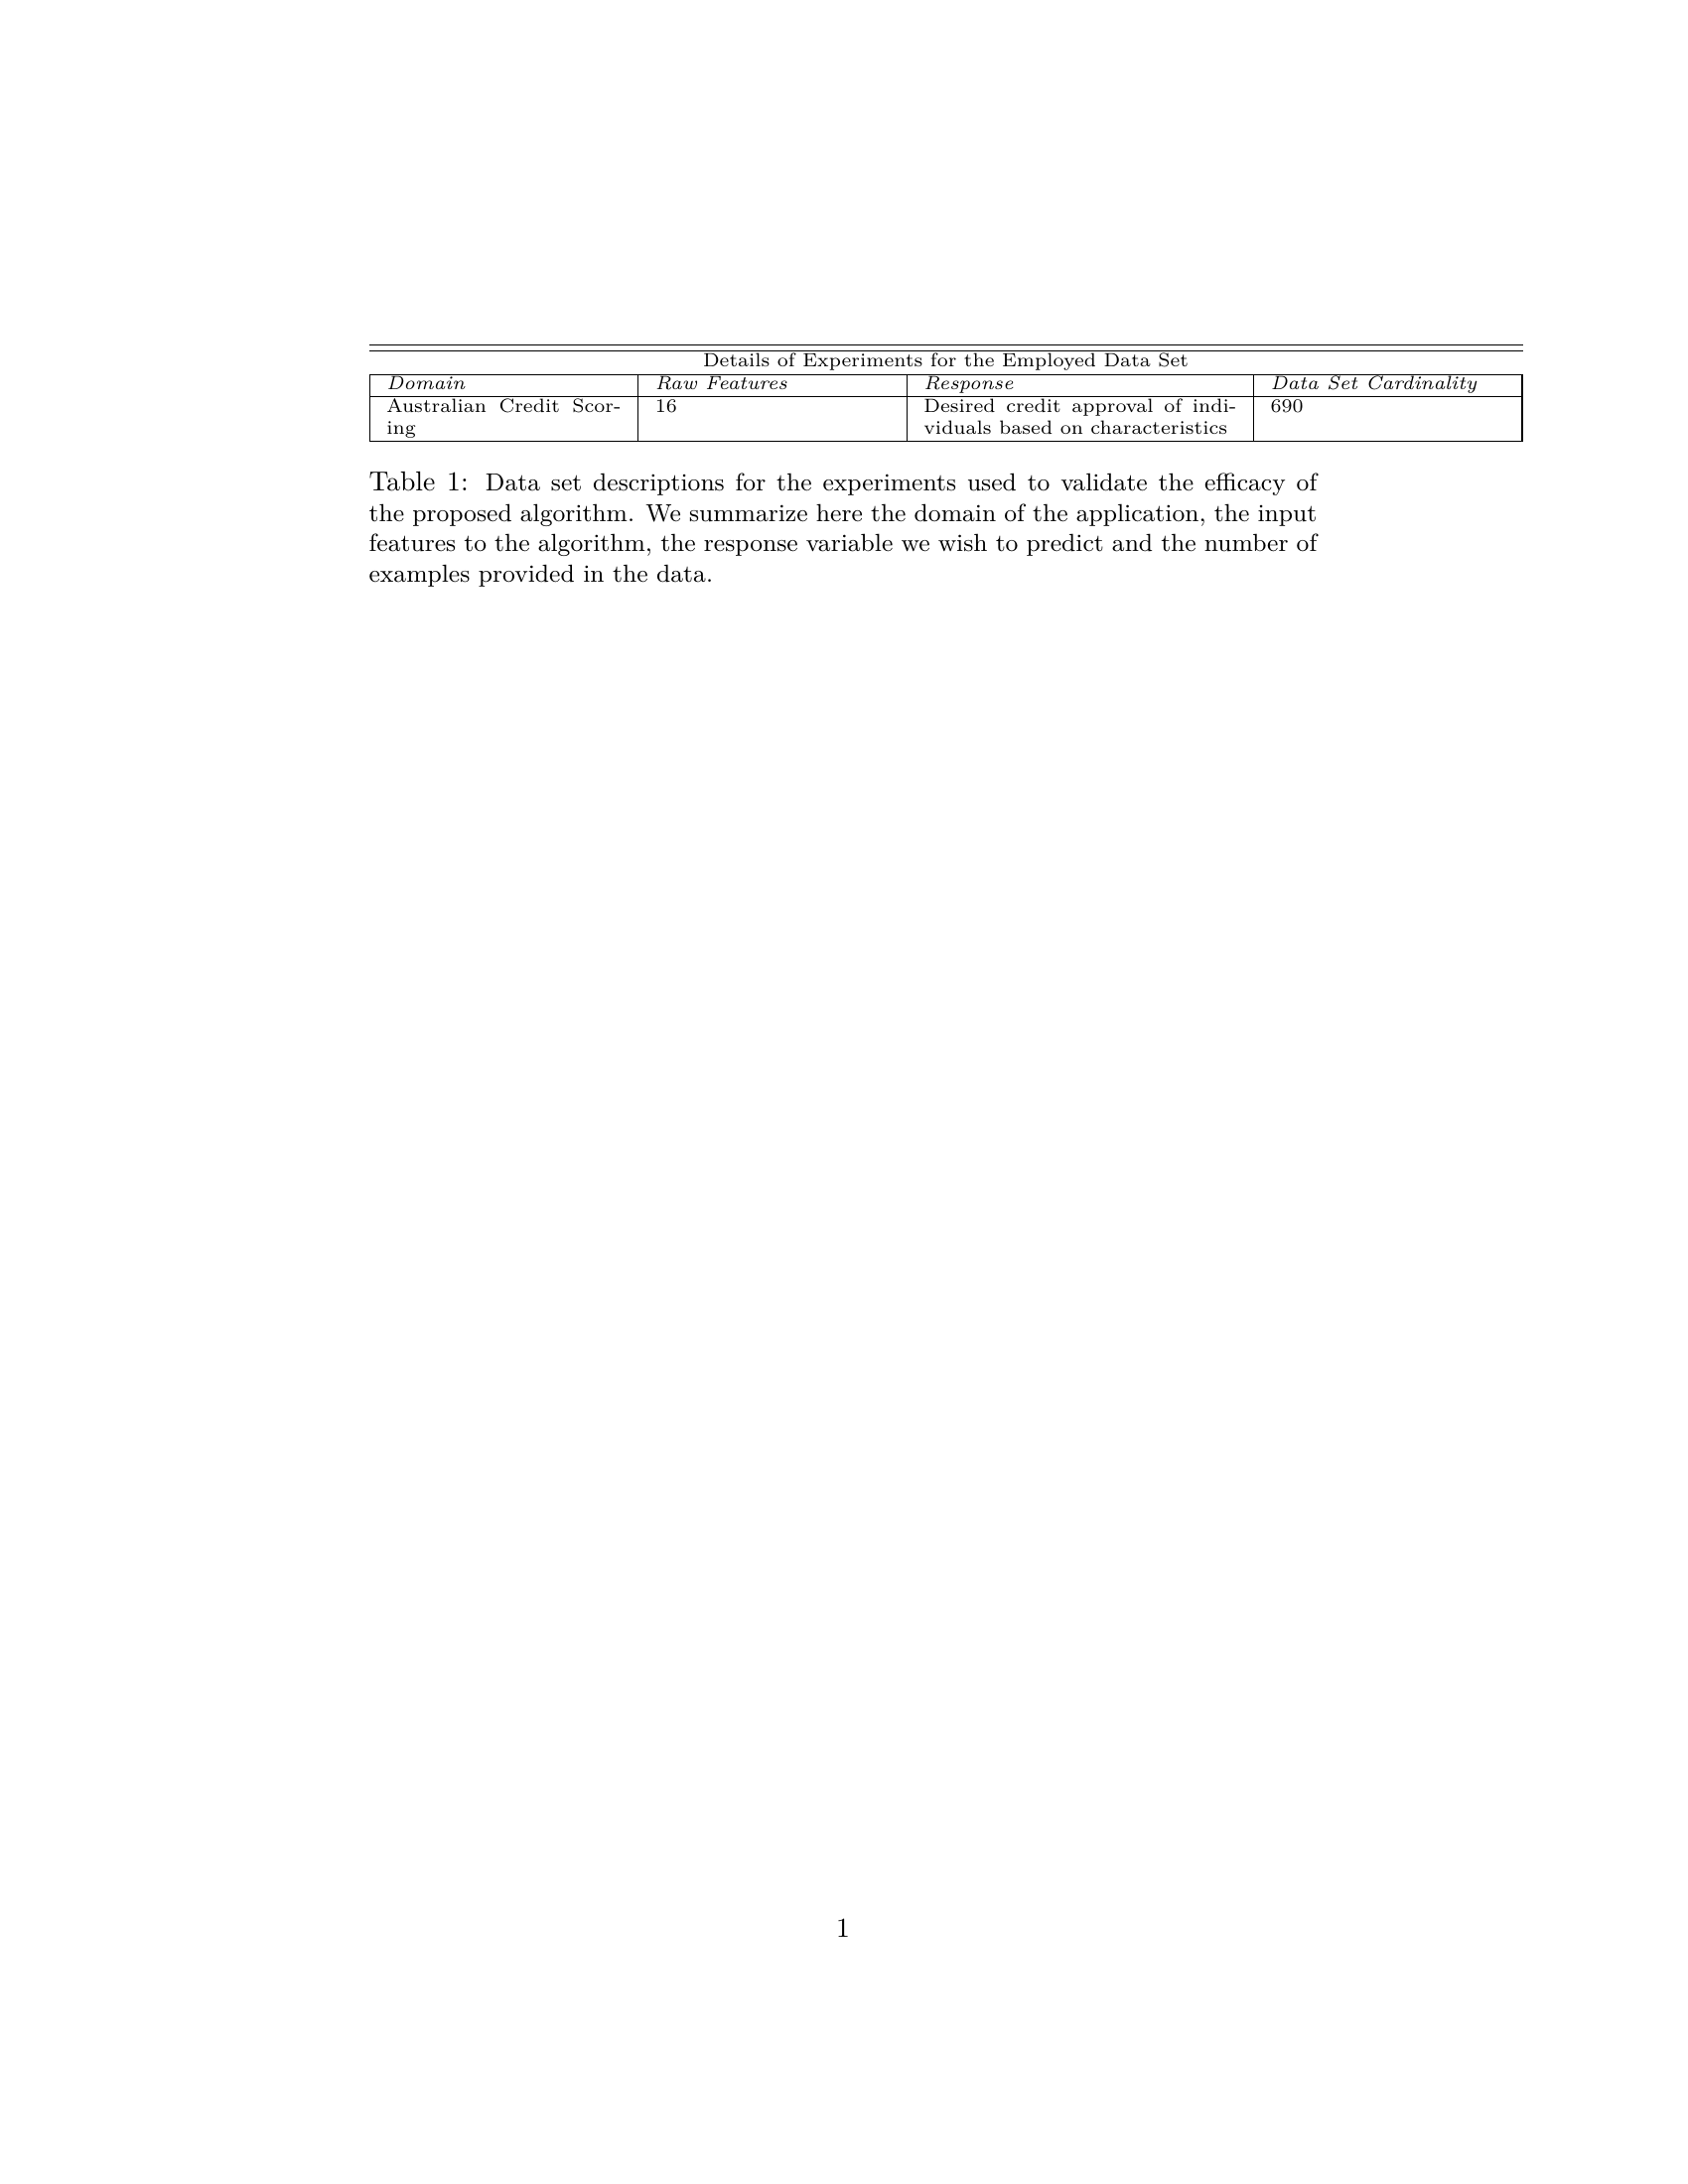

开始渲染： outputs/sample_0_20250524_003910_modified
图像数量： 1
PNG 是否生成： True


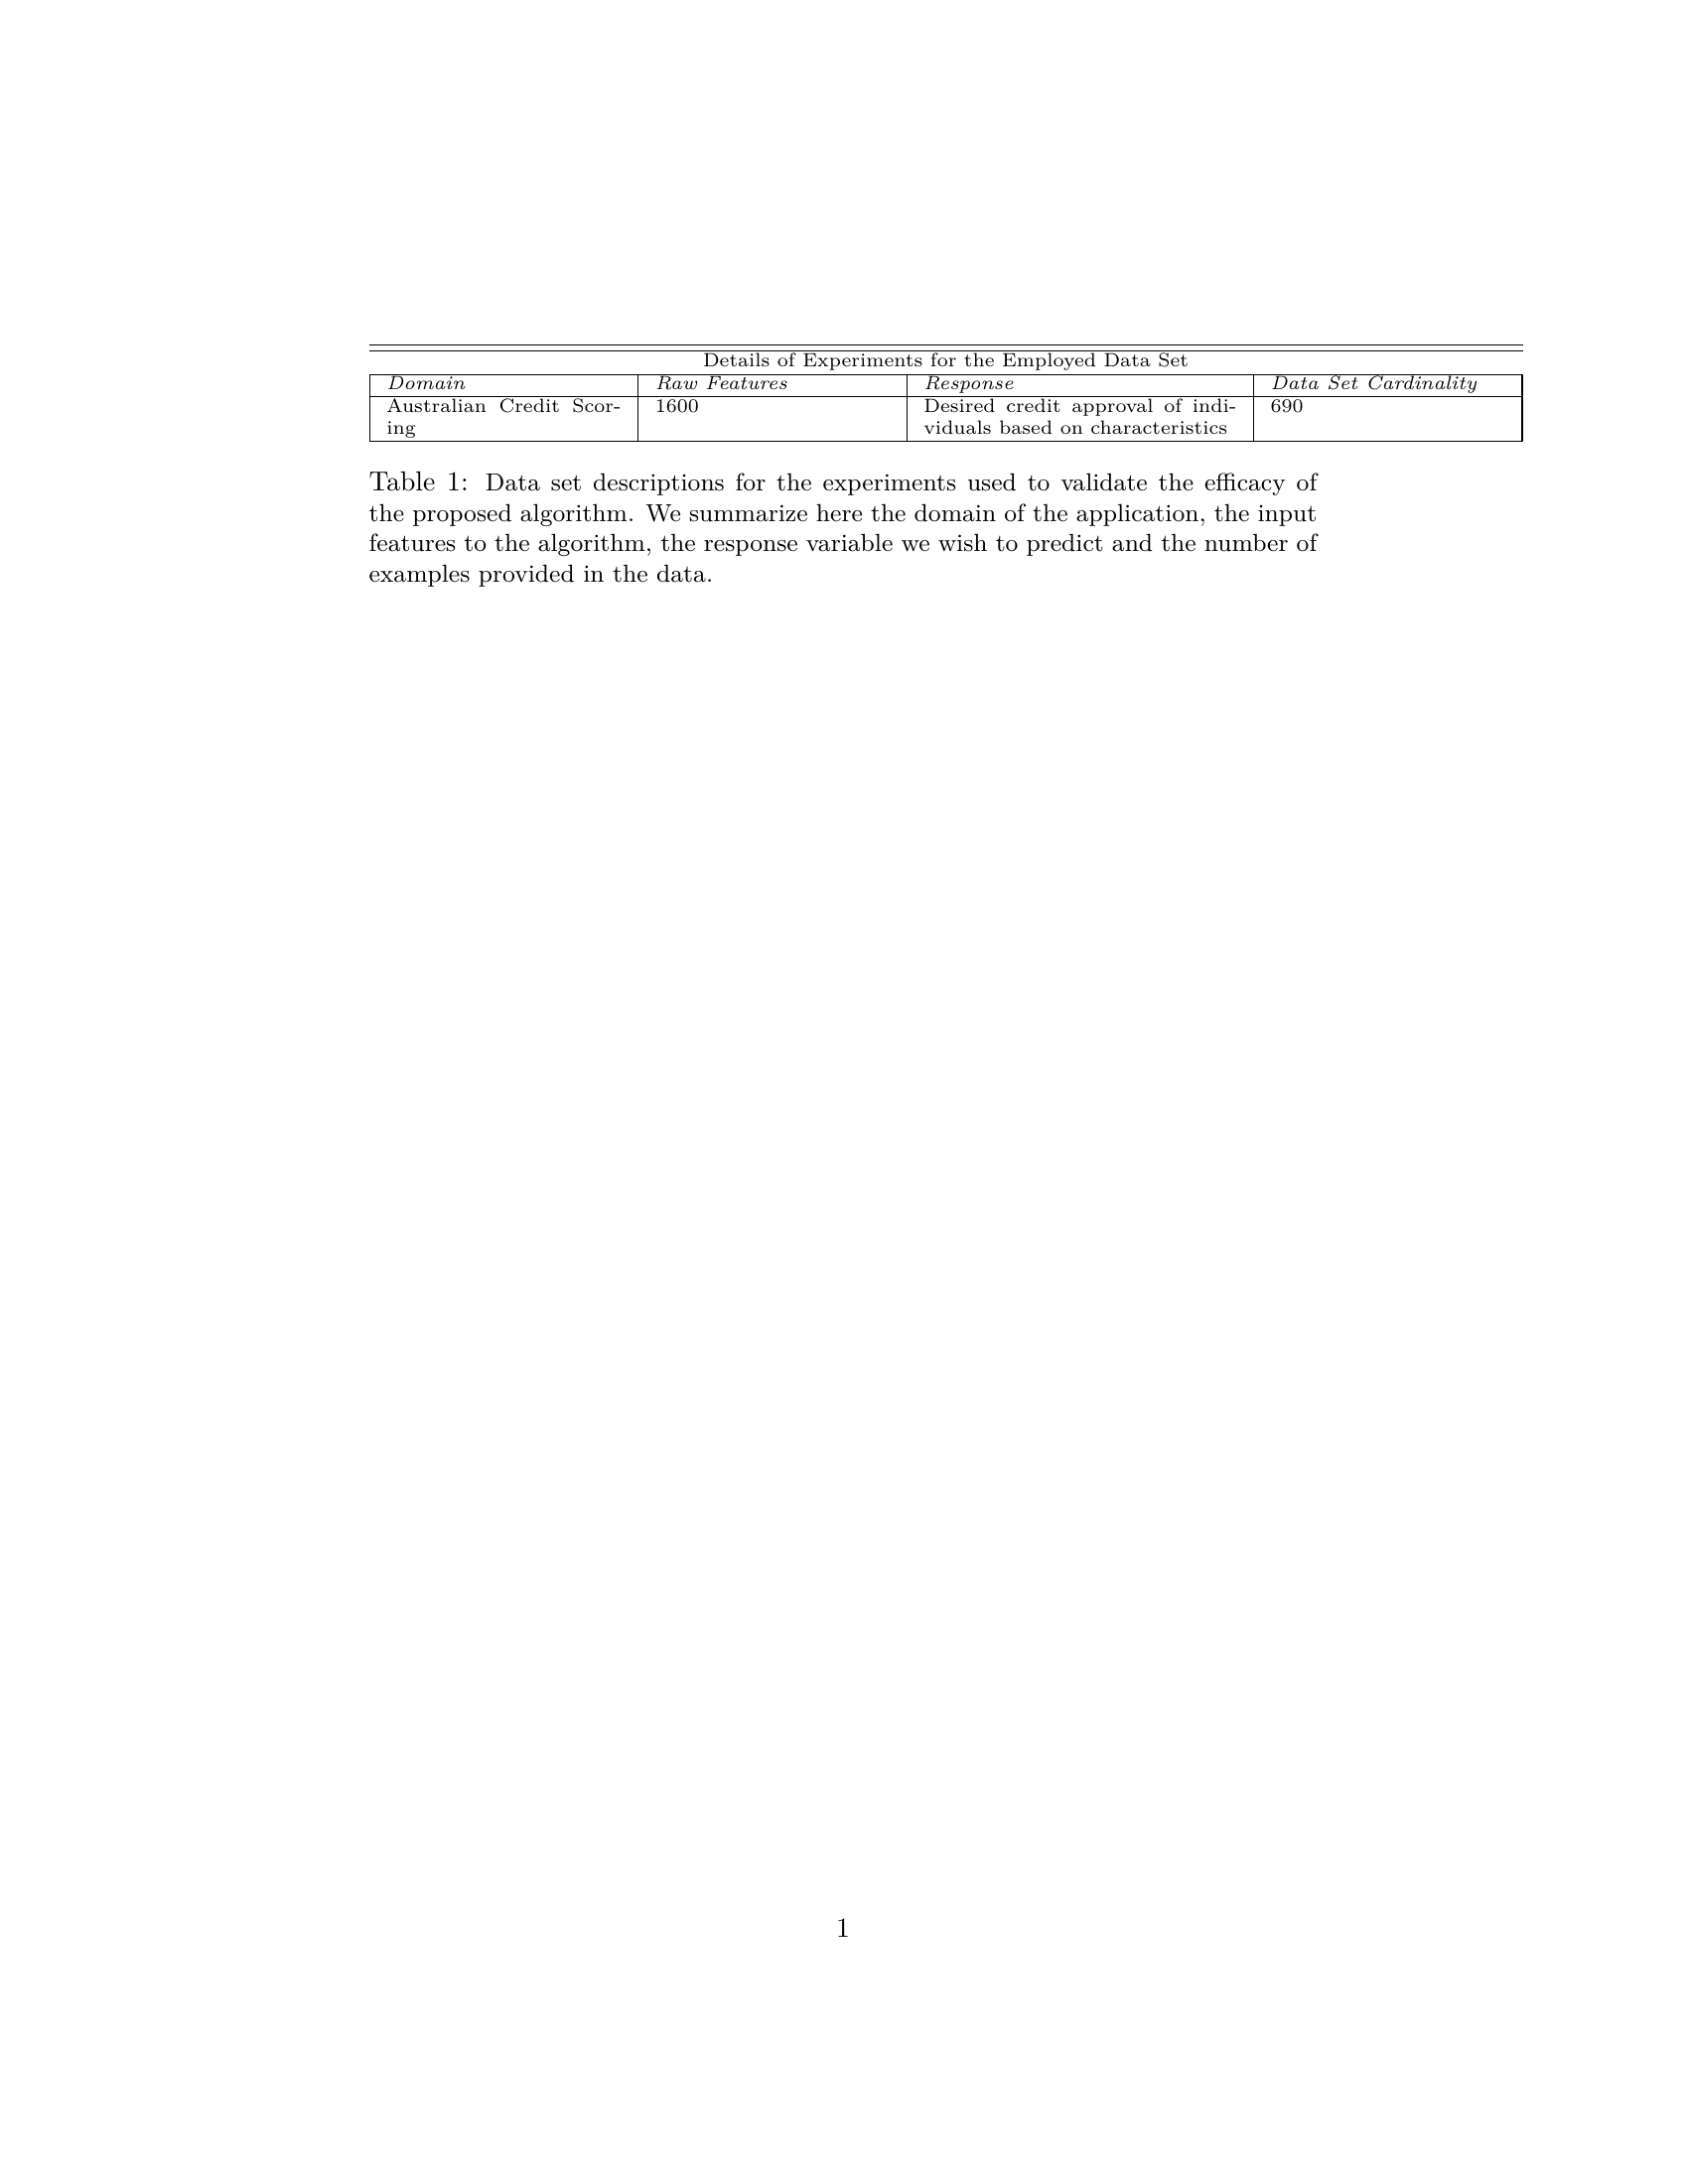

Modification complete. Image saved.

开始渲染： outputs/sample_1_20250524_003928_original
图像数量： 1
PNG 是否生成： True


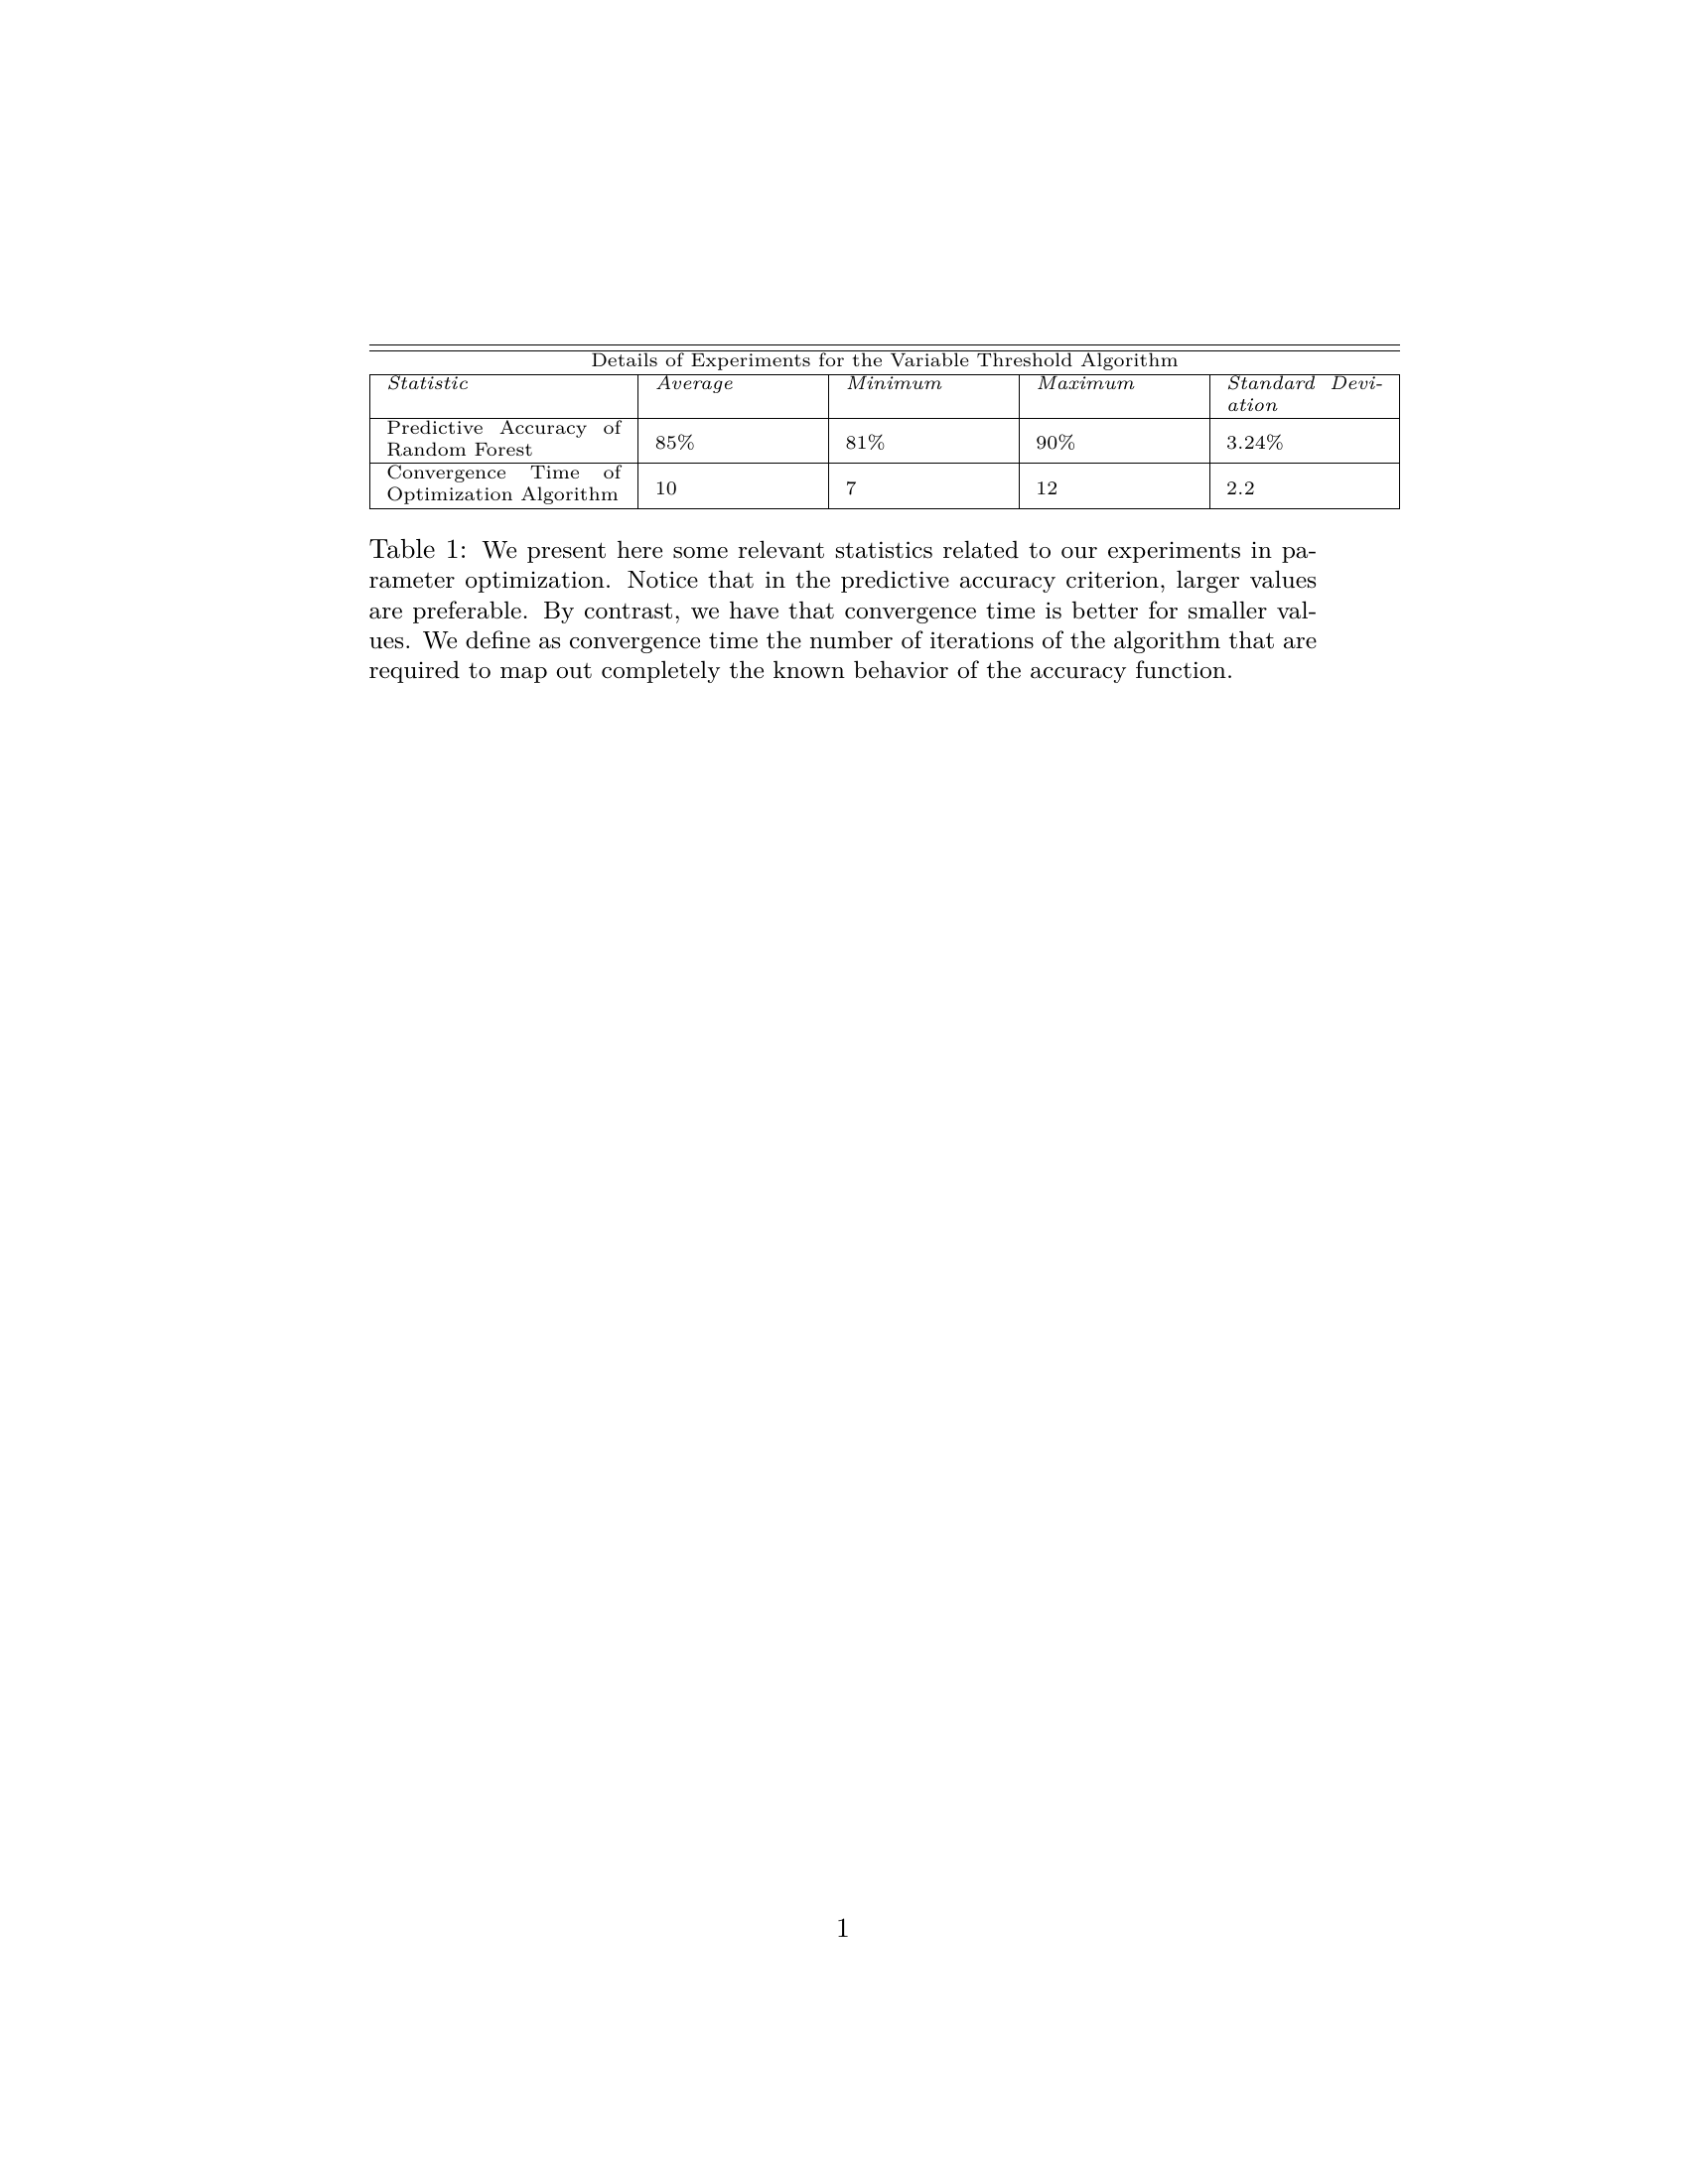

In [ ]:

# Load dataset
dataset = load_dataset("staghado/ArXiv-tables")["train"]
os.makedirs("outputs", exist_ok=True)
# 批量渲染前3张
batch_render_tables(dataset, start=0, end=3) 

for i in range(len(dataset)):
    latex = dataset[i]["latex_content"]
    if "\\begin{tabular}" not in latex: 
        continue

    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    name_base = f"outputs/sample_{i}_{timestamp}"

    try:
        # Render and display original image
        save_latex_as_image(latex, outname=f"{name_base}_original")
        display(Image(filename=f"{name_base}_original.png"))
    except Exception as e:
        print(f"Table {i+1} failed to render. Skipping. Reason: {e}")
        continue

    # Ask if the user wants to modify the table
    should_modify = input(f"Do you want to modify table {i+1}? (Y/N): ").strip().upper()
    if should_modify != "Y":
        continue

    # Ask how many values to modify
    try:
        n_changes = int(input("How many values would you like to modify?: ").strip())
    except ValueError:
        print("Invalid number. Skipping this table.")
        continue

    modified_latex = latex
    for j in range(n_changes):
        old_val = input(f"Original value #{j+1}: ").strip()
        new_val = input(f"New value #{j+1}: ").strip()
        modified_latex = modify_numeric_values(modified_latex, old_val, new_val)

    try:
        # Render and display modified image
        save_latex_as_image(modified_latex, outname=f"{name_base}_modified")
        display(Image(filename=f"{name_base}_modified.png"))
        print("Modification complete. Image saved.\n")
    except Exception as e:
        print(f"Failed to render modified table: {e}")

function that adds a new column

In [ ]:
def modify_column_spec(latex_line, default_addition="p{3cm}|", conditional_target="c|", conditional_addition="|c"):
    brace_count = 0
    first_done = False
    start_idx = None
    end_idx = None

    for i, char in enumerate(latex_line):
        if char == '{':
            brace_count += 1
            if brace_count == 1 and not first_done:
                first_done = True
            elif brace_count == 1 and first_done and start_idx is None:
                start_idx = i + 1  # content starts after this
        elif char == '}':
            if brace_count == 1 and start_idx is not None and end_idx is None:
                end_idx = i  # content ends before this
                break
            brace_count -= 1

    if start_idx is not None and end_idx is not None:
        # Get original column spec
        colspec = latex_line[start_idx:end_idx]
        if conditional_target in colspec:
            addition = conditional_addition
        else:
            addition = default_addition
        new_colspec = colspec + addition
        return latex_line[:start_idx] + new_colspec + latex_line[end_idx:]
    else:
        return latex_line  # unchanged if not found

In [ ]:
def add_column_to_outermost_tabular(latex_str, new_cell_value=" NEW ",default_number=0):
    lines = latex_str.splitlines()
    new_lines = []
    nest = 0
    inside_outer_tabular = False

    for line in lines:
        stripped = line.strip()

        match = re.match(r'(\\begin\{tabular\})\{([^}]*)\}', stripped)
        if match:
            nest += 1
            if nest == 1:
                inside_outer_tabular = True
                original_start, colspec = match.groups()
                line = modify_column_spec(line)

        elif r'\end{tabular}' in stripped:
            if nest == 1:
                inside_outer_tabular = False
            nest -= 1
       

        # Modify only inside the outermost tabular
        if inside_outer_tabular:
            # Patch multicolumn if found
            if r'\multicolumn{' in line:
                line = re.sub(r'\\multicolumn\{(\d+)\}', lambda m: f'\\multicolumn{{{int(m.group(1)) + 1}}}', line)
            
            if r'\cline{' in line:
                line = re.sub(r'\\cline\{(\d+)-(\d+)\}', lambda m: fr'\cline{{{m.group(1)}-{int(m.group(2))+1}}}', line)

            # Add a new cell to data rows
            if '&' in line and r'\\' in line:
                parts = line.split('&')
                parts.insert(-1, new_cell_value+str(default_number))
                default_number += 1
                line = ' & '.join(parts)

        new_lines.append(line)

    return '\n'.join(new_lines)

In [ ]:
from datasets import load_dataset

dataset = load_dataset("staghado/ArXiv-tables", split="train")

# Check available keys in first entry
print(dataset[0].keys())

/Users/kaizhi/Documents/semester3-exchange/nlp/project/RAG_on_arXiv_ML/nlp_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


dict_keys(['id', 'arxiv_id', 'page', 'bounding_box', 'latex_content', 'extracted_content', 'similarity_score', 'table_image', 'page_image'])


In [ ]:
# Load dataset
import re
dataset = load_dataset("staghado/ArXiv-tables", split="train")

# Process the first 3 entries
for i in range(3):
    original = dataset[i]["latex_content"]
    modified =add_column_to_outermost_tabular(original)
    #modified = replace_last_line_with_end_table(modified)

    print(f"\n--- Table {i}: Original ---\n")
    print(original[:800])
    
    print(f"\n--- Table {i}: Modified ---\n")
    print(modified[:1000])


--- Table 0: Original ---

\begin{table}[H]
    \centering
    \scriptsize
    \begin{tabular}{|p{3cm}|p{3cm}|p{4cm}|p{3cm}|}
      \hline
      \hline
      \multicolumn{4}{c}{Details of Experiments for the Employed Data Set}\\
      \cline{1-4}
      \emph{Domain} & \emph{Raw Features} & \emph{Response} & \emph{Data Set Cardinality}\\
      \hline
      Australian Credit Scoring & 16 & Desired credit approval of individuals based on characteristics & 690\\\hline
    \end{tabular}
    \caption{\small Data set descriptions for the experiments used to validate the efficacy of the proposed algorithm. We summarize here the domain of the application, the input features to the algorithm, the response variable we wish to predict and the number of examples provided in the data.}
  \end{table}

--- Table 0: Modified ---

\begin{table}[H]
    \centering
    \scriptsize
    \begin{tabular}{|p{3cm}|p{3cm}|p{4cm}|p{3cm}|p{3cm}|}
      \hline
      \hline
      \multicolumn{5}{c}{Details of Experi